# BAL Spectra analysis
In this notebook, I compare Spectra factors between RPRA and healthy subjects as follows:

1. For each cell type, subjects are filtered using the same criteria as during DGE analysis.
2. For each subject and each cell type, the mean cell score for each factor is computed. We refer to this score as the subject score.
2. For each cell type, a Wilcoxon rank sum test is used to test whether the RPRA subject scores are stochastically greater than the healthy subject scores.

In [1]:
import math
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import scipy
import pickle
import csv
from statsmodels.stats.multitest import fdrcorrection
from collections import Counter
from itertools import groupby
import matplotlib.patches as patches

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

## Read in data

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
adata = sc.read_h5ad(f"{data_dir}/01NEP/01integrated_NEP_GEO_v2/01integrated_NEP_GEO_v2.h5ad")

In [4]:
# Omit erythrocytes
adata = adata[adata.obs.cell_type != "Erythrocytes"].copy()

In [5]:
cell_types = adata.obs.cell_type.cat.categories.to_list()

## Compute cell and subject scores

In [6]:
def get_factor_celltypes(adata, obs_key):
    cell_scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'])
    cell_scores_df['celltype'] = list(adata.obs[obs_key])
    
    global_factors_series = (cell_scores_df.groupby('celltype').mean() != 0).all()
    global_factors = [factor for factor in global_factors_series.index if global_factors_series[factor]]
    specific_cell_scores = (cell_scores_df.groupby('celltype').mean()).T[~global_factors_series].T
    specific_factors = {}
    
    for i in set(cell_scores_df['celltype']):
        specific_factors[i] = [factor for factor in specific_cell_scores.loc[i].index if
                               specific_cell_scores.loc[i, factor]]
    
    factors_inv = {}
    for i,v in specific_factors.items():
        for factor in v:
            factors_inv[factor] = i
    
    for factor in global_factors:
        factors_inv[factor] = 'global'
            
    return factors_inv

In [7]:
factor_celltypes = get_factor_celltypes(adata, 'cell_type_spectra')

# Obtain gene weights
gene_weights = pd.DataFrame(
    adata.uns['SPECTRA_factors'], 
    index = [f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])],
    columns = adata.var[adata.var['spectra_vocab']].index
).T

# Obtain cell scores
cell_scores = pd.DataFrame(
    adata.obsm['SPECTRA_cell_scores'], 
    index = adata.obs_names,
    columns = [f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])]
)

# Map pathway names to factor names
with open(f"{data_dir}/01NEP/spectra/orig_factor_names_map.pkl", 'rb') as f:
    orig_factor_names_map = pickle.load(f)
factor_names_map = {k: ''.join(v.split('_')[:2]) for k, v in orig_factor_names_map.items()}
gene_weights.columns = pd.Index([factor_names_map[x] for x in gene_weights.columns])
cell_scores.columns = pd.Index([factor_names_map[x] for x in cell_scores.columns])

In [8]:
# Write top 100 genes per factor
gene_dict = {}
weight_dict = {}
ngene = 100
for pw in gene_weights.columns:
    top_genes = gene_weights[pw].sort_values(ascending = False)[0:ngene]
    gene_dict[pw] = top_genes.index.tolist()
    weight_dict[pw] = top_genes
    
with open(f"{data_dir}/01NEP/spectra/top_genes.csv", 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(["Pathway", "Gene", "Weight"])
    for k in gene_dict.keys():
        pairs = list(zip(gene_dict[k], weight_dict[k]))
        for g,w in pairs:
            writer.writerow([k, g, w])

In [9]:
# Add metadata to cell scores
cell_scores["Status"] = adata.obs.Status.astype(str)
cell_scores["Study_ID"] = adata.obs.Study_ID.astype(str)
cell_scores["cell_type"] = adata.obs.cell_type.astype(str)

In [10]:
# Compute subject scores as mean cell score
subject_scores = cell_scores.groupby(['Study_ID', 'cell_type', 'Status']).agg(['mean', 'count']).reset_index()

# Record number of cells for each subject/cell type combination
count_cols = subject_scores.columns.get_level_values(1) == 'count'
counts = subject_scores.iloc[:, count_cols].iloc[:, [0]].droplevel(1, axis = 1)
subject_scores = subject_scores.iloc[:, ~count_cols].droplevel(1, axis = 1)
subject_scores.insert(3, 'n_cell', counts)

## Same filtering as in DEG analysis
We prefilter factors which have zero expression across all subjects.

In [11]:
MIN_CELLS = 40
CUTOFF = 0.01
def get_ct_score(cell_type, sfilt):
    ct_scores = subject_scores.loc[subject_scores.cell_type == cell_type].copy()
    if sfilt:
        total_cells = np.sum(adata.obs.cell_type == cell_type)
        cutoff = math.floor(CUTOFF * total_cells)
        ct_scores = ct_scores[ct_scores.n_cell > max(MIN_CELLS, cutoff)]
    ct_scores = ct_scores.loc[:, ct_scores.sum(axis = 0) != 0]
    return ct_scores

## All gene sets
The question we ask here is: in a given cell type, which factors are different between RPRA and healthy subjects? We consider all cell types separately, and therefore correct p-values for each cell type separately. This is in line with how we performed DEG analysis.

In [12]:
df_all = pd.DataFrame(columns = ['cell_type', 'Pathway', 'SNR', 'Upregulated', 'pval', 'padj'])
for ct in cell_types:
    df = pd.DataFrame(columns = ['cell_type', 'Pathway', 'SNR', 'Upregulated', 'pval'])
    
    # Require at least three subjects per condition for testing
    ct_scores = get_ct_score(ct, sfilt = True)
    if (ct_scores.shape[0] > 0) and ((ct_scores.Status.value_counts() >= 3).sum() == 2):
        rpra_scores = ct_scores.loc[ct_scores.Status == 'RPRA']
        ctrl_scores = ct_scores.loc[ct_scores.Status == 'Healthy']
        for pw in ct_scores.columns[4:]:
            pval = scipy.stats.mannwhitneyu(ctrl_scores[pw], rpra_scores[pw]).pvalue
            upreg = 'RPRA' if np.median(rpra_scores[pw]) > np.median(ctrl_scores[pw]) else 'Healthy'

            signal = (np.mean(rpra_scores[pw]) - np.mean(ctrl_scores[pw]))
            noise = (np.std(rpra_scores[pw]) + np.std(ctrl_scores[pw]))
            snr = signal / noise

            df = pd.concat([df, pd.DataFrame([[ct, pw, snr, upreg, pval]], columns = df.columns)],
                           ignore_index = True)
        _, df['padj'] = fdrcorrection(df.pval, alpha = 0.05, method = 'p')
    else:
        ct_scores = get_ct_score(ct, sfilt = False)
        rpra_scores = ct_scores.loc[ct_scores.Status == 'RPRA']
        ctrl_scores = ct_scores.loc[ct_scores.Status == 'Healthy']
        
        for pw in ct_scores.columns[4:]:
            signal = (np.mean(rpra_scores[pw]) - np.mean(ctrl_scores[pw]))
            if signal > 0:
                noise = (np.std(rpra_scores[pw]) + np.std(ctrl_scores[pw]))
                snr = signal / noise
            else:
                snr = 0
            df = pd.concat([df, pd.DataFrame([[ct, pw, snr, None, None]], columns = df.columns)],
                           ignore_index = True)
        df['padj'] = None
    
    df_all = pd.concat([df_all, df])
    
df_all = df_all.reset_index(drop = True)

In [13]:
df_all_filt = df_all[~np.isnan(df_all.pval)].copy()
df_all_filt = df_all_filt[df_all_filt.padj <= 0.05].reset_index(drop = True)
df_all_filt

,cell_type,Pathway,SNR,Upregulated,pval,padj


In [14]:
mat = df_all.drop(columns = ['Upregulated', 'pval', 'padj'])
mat = mat.pivot(index = 'cell_type', columns = 'Pathway', values = 'SNR')
mat = mat.loc[:, mat.abs().sum(axis = 0) != 0].T
mat = mat.fillna(0)
mat.index = pd.Index([''.join(x.split('_')[0:2]) for x in mat.index])

In [15]:
gmax = np.abs(mat.to_numpy()).max()
g = sns.clustermap(mat.T, z_score = None, xticklabels = 1, yticklabels = 1, cmap = 'coolwarm',
                   figsize = (16, 8), cbar_pos = (0.975, 0.4, 0.025, 0.3), dendrogram_ratio = 0.1,
                   center = 0, vmin = -gmax, vmax = gmax)

g.ax_heatmap.tick_params(axis = 'x', labelsize = 11, rotation = 0)
g.ax_heatmap.tick_params(axis = 'y', labelsize = 11)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)
g.ax_heatmap.text(40.8, 4.4, "Up in RPRA", fontsize = 11)
g.ax_heatmap.text(40.8, 12.8, "Down in RPRA", fontsize = 11)

plt.savefig(f"{data_dir}/figures/fig_s6/fig_s6_c.pdf", bbox_inches = 'tight', transparent = True)
plt.close()

## Heatmap

In [16]:
all_scores = get_ct_score(cell_types[0], sfilt = False)
for ct in cell_types[1:]:
    all_scores = pd.concat([all_scores, get_ct_score(ct, sfilt = False)])
all_scores = all_scores.reset_index(drop = True)

In [17]:
all_scores.cell_type = pd.Categorical(all_scores.cell_type)
cell_order = ['Basal cells', 'MMP9 basal cells', 'Proliferating basal cells', 'Suprabasal cells',
              'Secretory cells', 'Squamous cells', 'Mucous cells', 'Secretory ciliated cells',
              'Deuterosomal cells', 'Ciliated cells', 'Ionocytes', 'Fibroblasts', 'Mast cells', 'Monocytes',
              'Macrophages', 'DC2', 'pDC', 'B cells', 'CD4 T cells', 'CD8 T cells', 'gdT cells']
all_scores.cell_type = all_scores.cell_type.cat.set_categories(cell_order, ordered = True)
all_scores = all_scores.sort_values('cell_type')

In [18]:
all_scores_sub = all_scores.drop(columns = ["Study_ID", "cell_type", "Status", "n_cell"]).fillna(0)
all_scores_sub.index = pd.Index(all_scores.cell_type)
all_scores_sub = all_scores_sub.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

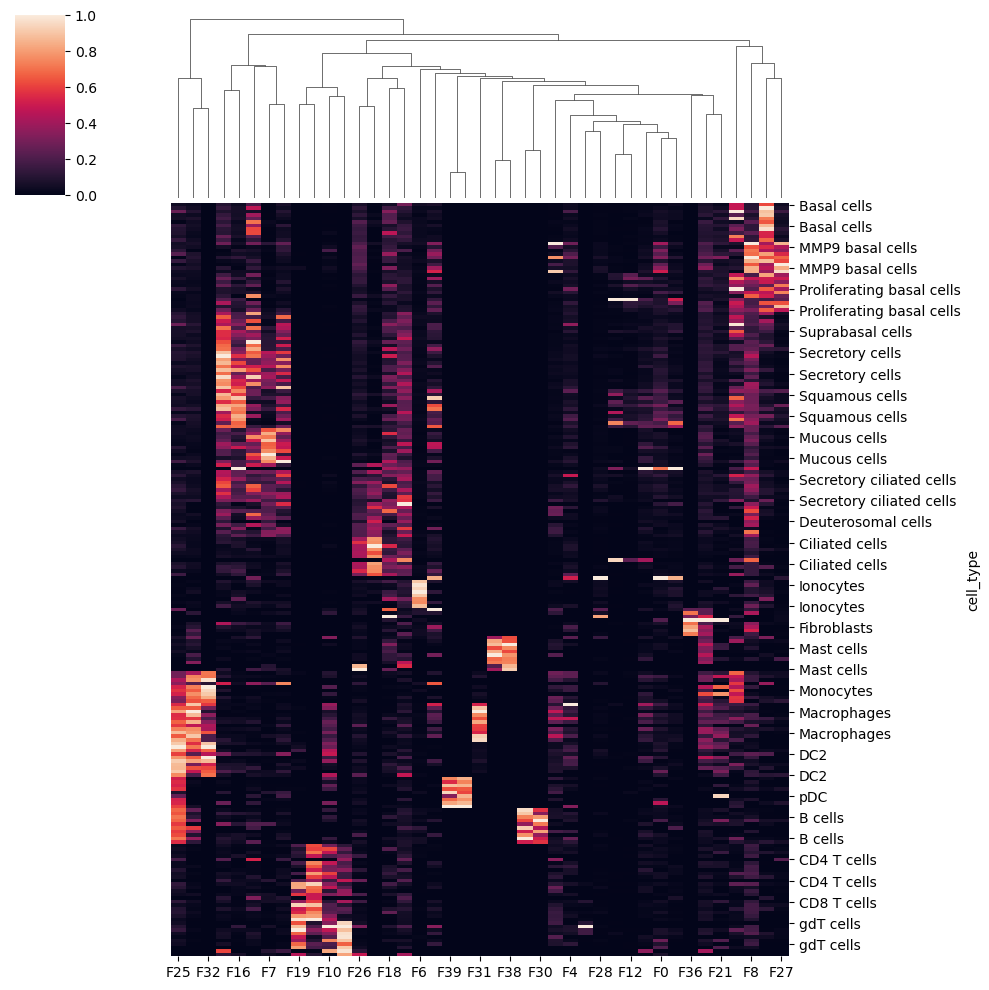

In [19]:
clmap = sns.clustermap(all_scores_sub, row_cluster = False, col_cluster = True)
col_inds = clmap.dendrogram_col.reordered_ind
sorted_scores = all_scores_sub.iloc[:, col_inds[::-1]]

In [20]:
sorted_scores.columns = pd.Index([''.join(x.split('_')[0:2]) for x in sorted_scores.columns])

In [21]:
sorted_scores.index = sorted_scores.index.str.replace('Basal cells', 'Basal cells')
sorted_scores.index = sorted_scores.index.str.replace('MMP9 basal cells', 'MMP9 basal')
sorted_scores.index = sorted_scores.index.str.replace('Proliferating basal cells', 'Prolif. basal')
sorted_scores.index = sorted_scores.index.str.replace('Suprabasal cells', 'Suprabasal')
sorted_scores.index = sorted_scores.index.str.replace('Secretory cells', 'Secretory')
sorted_scores.index = sorted_scores.index.str.replace('Squamous cells', 'Squamous')
sorted_scores.index = sorted_scores.index.str.replace('Secretory ciliated cells', 'Secr. ciliated')
sorted_scores.index = sorted_scores.index.str.replace('Deuterosomal cells', 'Deuterosomal')

In [22]:
fig = plt.figure(figsize = (26, 12))
ax = fig.add_subplot()
sns.heatmap(sorted_scores.T, cbar_kws = {"shrink": 0.4, "pad": 0.015}, yticklabels = 1, linecolor = 'black')

ax.set_xlabel('')
ax.set_xticklabels([''] * len(ax.get_xticklabels()))
ax.tick_params(axis = 'x', which = 'both', bottom = False)
ax.tick_params(axis = 'y', labelsize = 10)

cell_types = sorted_scores.index.unique().tolist()
palette = sns.color_palette("muted")
colors = []
for i in range(int(np.ceil(len(cell_types) / len(palette)))):
    colors += palette

lw = 0.95
sc = 0
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1] - lw))
offset = [0.2, 0.9, 0, 0, 0.9, 0.3, 0.05, -0.25, -0.39, -0.4, 1.8, 1.8, 1, 1.25, -0.5, 3, 4, 2.3, 0.3, 0.1, 1.3]
for i in range(len(cell_types)):
    nc = np.sum(sorted_scores.index == cell_types[i])
    ax.add_patch(patches.Rectangle((sc, -lw), nc, lw, edgecolor = 'k', facecolor = colors[i]))
    ax.text(sc + nc - 9.5 + offset[i], -0.3, cell_types[i], size = 10)
    sc += nc

plt.tight_layout()
plt.savefig(f"{data_dir}/figures/fig_s6/fig_s6_d.pdf", bbox_inches = 'tight', transparent = True, dpi = 300)
plt.close()